# seasonal data analysis

The data was found on kaggle : https://www.kaggle.com/datasets/sandeeptudu/indian-major-cities-daily-temperatures-1995-2019 
The dataset contains daily temperature for four major cities in India : Kolkata , Mumbai , Chennai , Delhi. But we will only be interested in the first day of each month.
The dataset has been curated from : academic.udayton.edu.
We will be looking at 2 columns :

Date - The date of the observation


mumbai - the daily temperature in mumbai (in Farenheights)

In [1]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plots
from statsmodels.tsa.seasonal import seasonal_decompose, STL # to check for seasonality
from statsmodels.tsa.stattools import adfuller # augmented Dickey-Fuller test

# ploting the time series versus time

We are only plotting the time series for the city of mumbai, we are combining day month and year into a single column called 'date' and we will only display the first day of each month from 2004 to 2019.


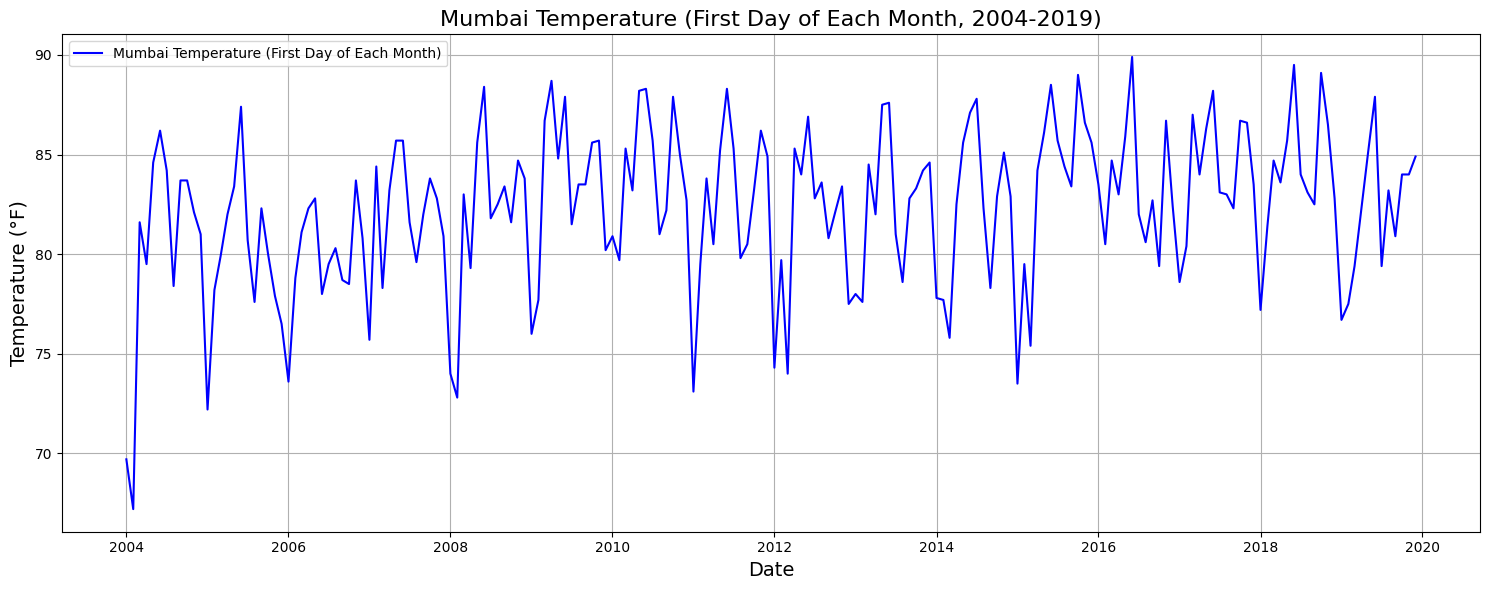

In [15]:

# load CSV file
file_path = "./Daily Temperatures 1995-2019 for Major Indian Cities.csv"
data = pd.read_csv(file_path)

# combine year, month, and day into a single 'date' column
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# only Mumbai temperature and drop rows with missing values
data = data[['date', 'mumbai']].dropna()

# Convert 'mumbai' column to float, coercing invalid values to NaN
data['mumbai'] = pd.to_numeric(data['mumbai'], errors='coerce')

# remove rows where there might have been a conversion error, still works without it though...
# data = data.dropna(subset=['mumbai'])

data_filtered = data[(data['date'] >= '2004-01-01') & (data['date'] <= '2019-12-31')]

#only the first day of each month
data_first_day = data_filtered[data_filtered['date'].dt.is_month_start]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(data_first_day['date'], data_first_day['mumbai'], label='Mumbai Temperature (First Day of Each Month)', color='blue')
plt.title('Mumbai Temperature (First Day of Each Month, 2004-2019)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature (°F)', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('figures/Temperature_vs_time.png', dpi=300)



# checking for seasonality (using STL)

There seem to be a clear sesonal component in this time series, as indicated by the stl which helps us see it better by decomposing the time series into 3 parts : trend, seasonality and residual.

In [3]:
# period is the number of observations in the cycle
advanced_decomposition = STL(data_first_day.mumbai, period=12).fit()

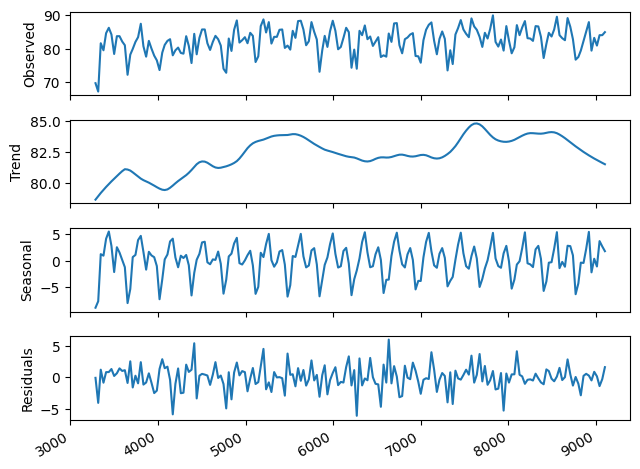

In [16]:
# decomposing the time series into Trend, Seasonality and residual
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('figures/STL.png', dpi=300)



# Dickey-Fuller(ADF) test to see if the data is stationary or not

The ADF statistic is a negative number (-5.56), but the p-value is higher (0.28) than 0.05,which means we can't reject the null
hypothesis stating that our time series is not stationary (here, that means that the data has a trend and seasonality).


Therefore, the data for this time series might need to be transformed using a diferenciation.

In [ ]:
# Perform the ADF test on the 'weekly sales' column of the 'dfstore' dataframe
ADF_result = adfuller(data_first_day['mumbai'])

# Print the ADF statistic obtained from the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

#Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.00960105422223
p-value: 0.28237930337255346


In [ ]:
mumbai_diff = np.diff(data_first_day['mumbai'], n=1)

We perform the ADF again on the diferenciated time series, we can observe that the p-value is now lower that 0.05 which means we can reject the null hypothesis. our data is stationary. the d parameter we need to use in the SARIMA model will be one).


In [ ]:
# Perform the ADF test on the 'weekly sales' column of the 'dfstore' dataframe
ADF_result = adfuller(mumbai_diff)

# Print the ADF statistic obtained from the ADF test
print(f'ADF Statistic: {ADF_result[0]}')

#Print the p-value obtained from the ADF test
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.84928047354776
p-value: 7.273163710633419e-22


# Plotting the auto corellation function (ACF) to get an idea of which model to apply

We notice some spikes at certain lags: lag 1, 12, 24, 36, etc. which maches the number of month in a year, it shows that temperature data has a seasonal.
there are many spikes that fall outside the confidence interval, this indicates a statistically significant autocorrelation at those lags.

the autocorelation slowly becomes less significant as the lags increase.

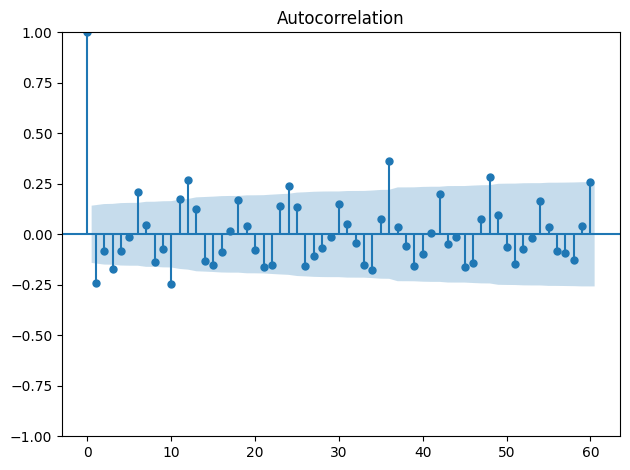

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(mumbai_diff, lags=60)
plt.tight_layout()
plt.savefig('figures/acf.png', dpi=300)


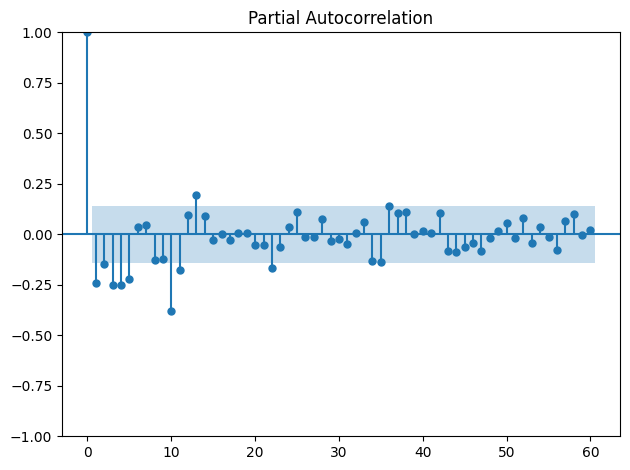

In [18]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(mumbai_diff, lags=60)


plt.tight_layout()

plt.savefig('figures/pacf.png', dpi=300)

# Chosing the best parameters for SARIMA(p,d,q)(P,D,Q)m model

we already know that d = 1, and m = 12 (since the nb of observations per cycle is one per month).

Now we need to determin the rest of the parameters. By trying multiple combinations of parameters and chosing the one that gives the best results when we forcast it.